# Sparky Discord Bot

## Description:
    
    This Discord bot uses the LangChain library to create a question-answering system.
    It uses the Hugging Face Hub to download pre-trained models and embeddings,
    and integrates with the Qdrant vector database for efficient search.
    The bot also supports multi-step reasoning, allowing users to ask questions
    that require multiple pieces of information from different sources. It also lists the citations used for the information

    The bot also supports natural language inference (NLI) using the
    Google Generative AI model. To use NLI, you must provide a
    question and two options, and the bot will generate a third option
    that is most likely to be the correct answer.

    The current use for this bot is to provide answers to questions regarding arizona state university 



## Workflow

- The bot starts by connecting to the Qdrant vector database.
- It then retrieves relevant documents from the database using the ASU University's search terms.
- The bot uses the Hugging Face pipeline to generate answers based on the retrieved documents.
- If a user asks a question that requires multi-step reasoning, the bot will generate a series of answers, each based on the previous one.
- To handle natural language inference (NLI), the bot uses the Google Generative AI model.
- The bot is designed to handle a variety of questions related to ASU University, such as academic information, campus life, and student life.

<!-- 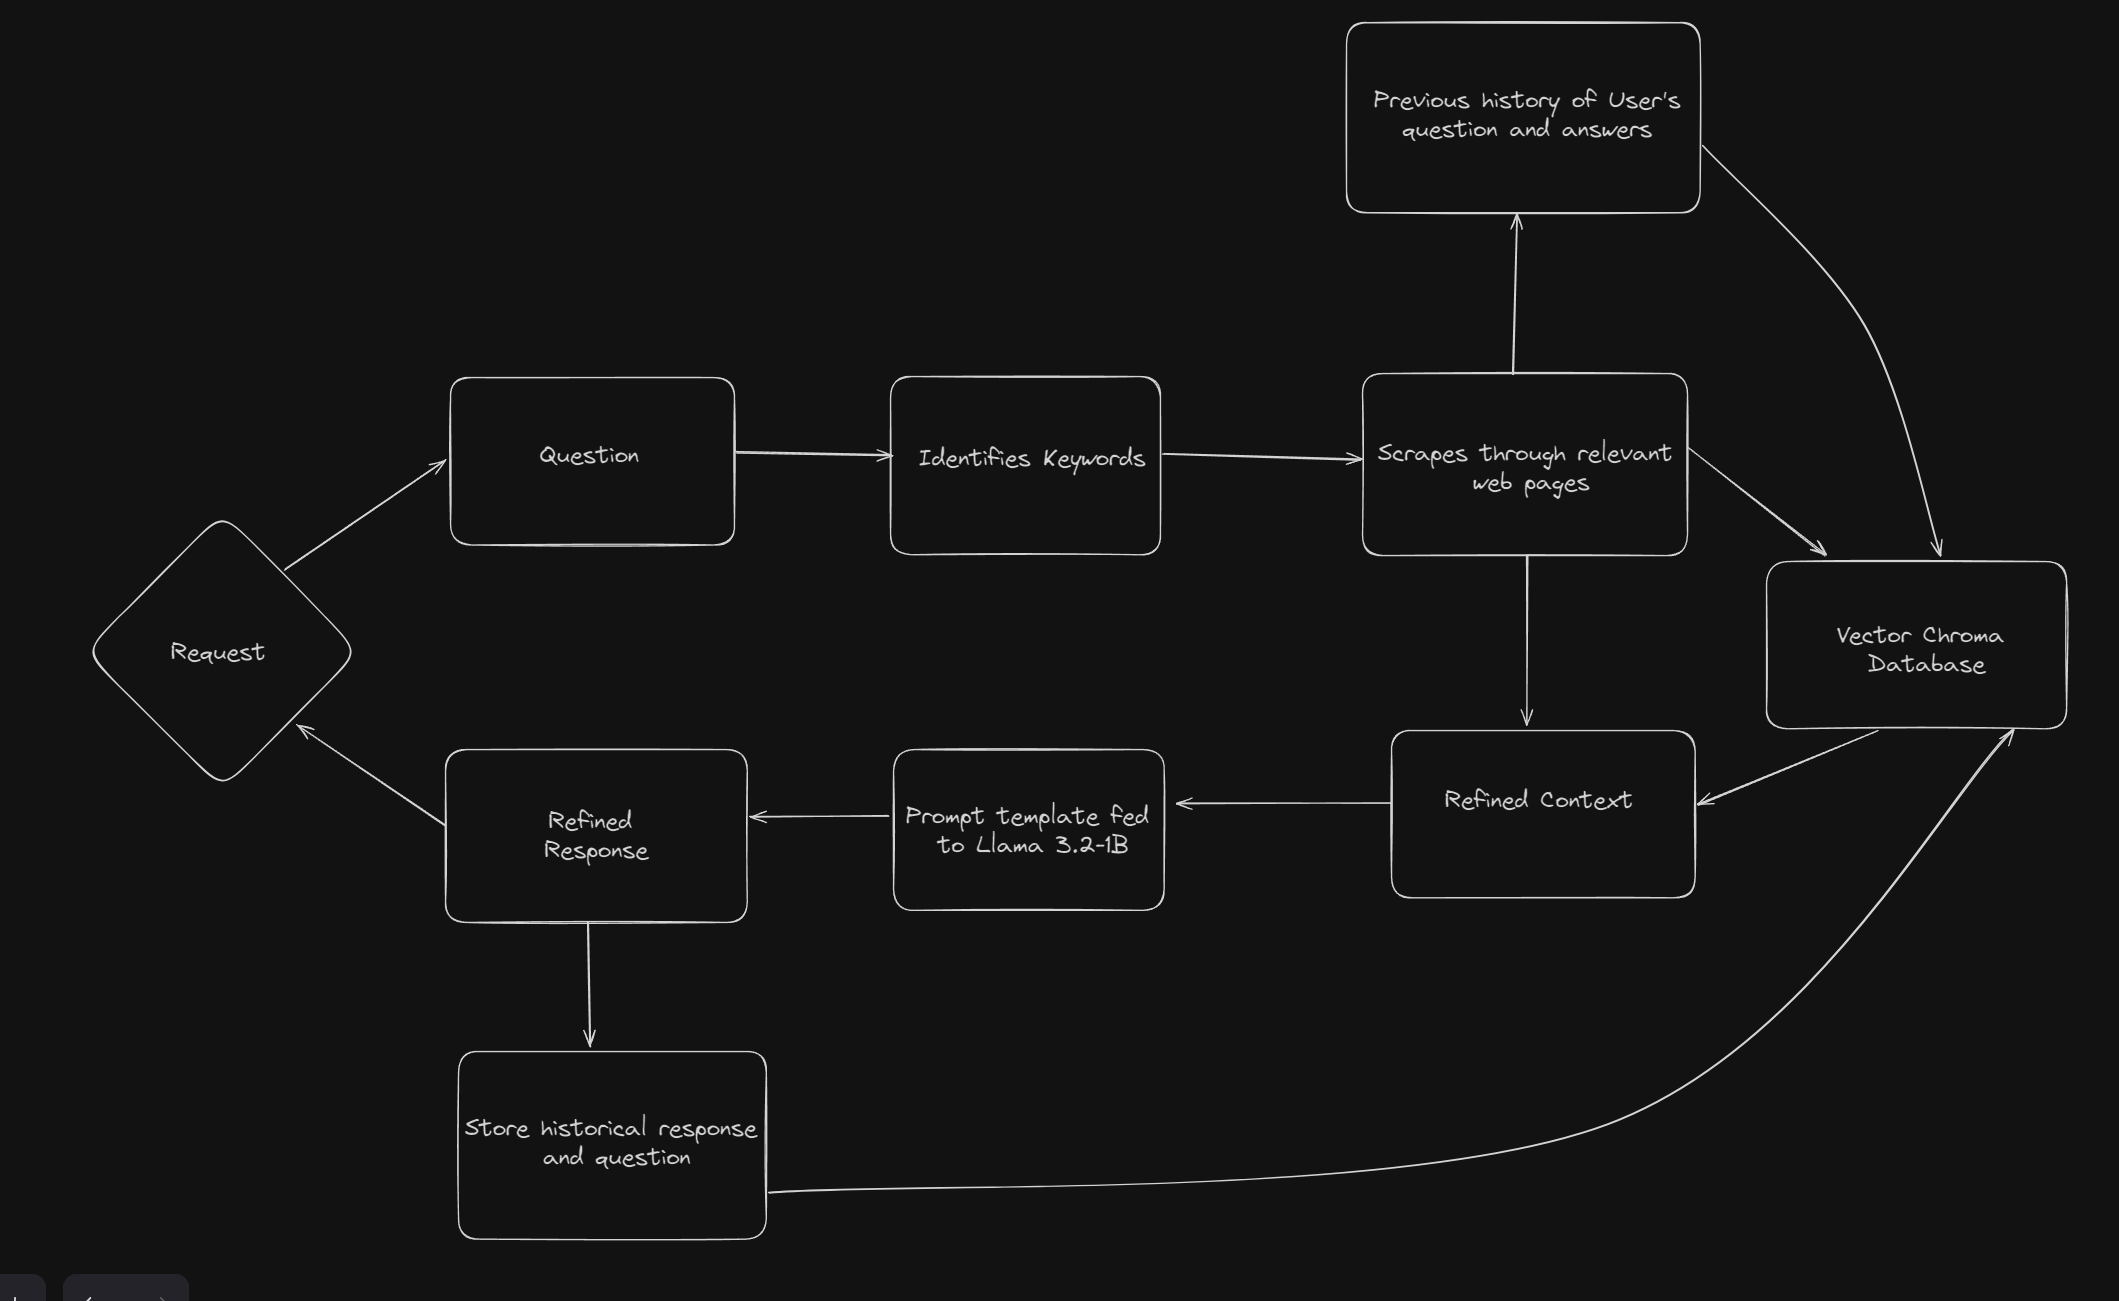 -->

In [ ]:
%pip install transformers 
%pip install langchain langchain-community llama-cpp-python langchain langchain-community huggingface_hub google-generativeai
%pip install accelerate qdrant-client requests beautifulsoup4 chromadb sentence_transformers faiss-gpu

### Importing Libraries

We are using [llama 3.1.2-1B Model](https://huggingface.co/meta-llama/Llama-3.2-1B) for providing efficient answers while utilizing [LangChain Library](https://python.langchain.com/docs/introduction/) for managing agents along with [Beautiful Soup](https://beautiful-soup-4.readthedocs.io/en/latest/) for minimal webscraping support

In [ ]:
import os

from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Qdrant
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch
from huggingface_hub import login
import warnings
warnings.filterwarnings('ignore')


os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""
geminia_api_key = ""
login()


### Defining the Web Scraping Class

This class has methods to find relevant webpages and perform webscraping to gather raw data from websites

In [ ]:
class ASUWebCrawler:
    def __init__(self, base_url="https://www.asu.edu"):
        self.base_url = base_url
        self.visited_urls = set()
        self.text_content = []
        self.relevant_paths = [
            '/admission', '/academics', '/programs',
            '/students', '/research', '/campus-life'
        ]
    
    def is_valid_url(self, url):
        return (
            "asu.edu" in url and 
            not any(ext in url.lower() for ext in ['.pdf', '.jpg', '.png', '.gif']) and
            any(path in url.lower() for path in self.relevant_paths)
        )
    
    def clean_text(self, text):
        return ' '.join(text.split())
    
    def crawl_page(self, url, max_depth=2, current_depth=0):
        if current_depth >= max_depth or url in self.visited_urls:
            return
        
        try:
            response = requests.get(url, timeout=5)
            self.visited_urls.add(url)
            
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                
                # Extract main content areas
                content_elements = soup.find_all(['article', 'main', 'section']) or soup.find_all(['p', 'h1', 'h2', 'h3'])
                print("extracting content elements : ", content_elements)

                text = ' '.join([
                    self.clean_text(element.get_text())
                    for element in content_elements
                    if element.get_text().strip()
                ])
                
                if len(text) > 100:  # Only store meaningful content
                    self.text_content.append({
                        'url': url,
                        'content': text
                    })
                
                # Find and follow relevant links
                if current_depth < max_depth:
                    for link in soup.find_all('a', href=True):
                        next_url = urljoin(url, link['href'])
                        print("following next_url ", next_url)
                        if self.is_valid_url(next_url):
                            self.crawl_page(next_url, max_depth, current_depth + 1)
                            
        except Exception as e:
            print(f"Error crawling {url}: {str(e)}")

### Creating DataPreProcessor Class

This class preprocesses the web scraped data by cleaning it, splitting it into chunks, and preparing it for vector storage in a vector database like Qdrant.

In [ ]:
class DataPreprocessor:
    def __init__(self):
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50
        )
    
    def clean_text(self, text):
        # Remove extra whitespace
        text = ' '.join(text.split())
        # Remove special characters
        text = ''.join(char for char in text if char.isalnum() or char.isspace())
        return text
    
    def process_documents(self, documents):
        cleaned_docs = []
        for doc in documents:
            cleaned_text = self.clean_text(doc['content'])
            print("cleaned_text : ", cleaned_text)
            if cleaned_text:
                cleaned_docs.append({
                    'content': cleaned_text,
                    'url': doc['url']
                })
        
        # Split documents into chunks
        splits = []
        for doc in cleaned_docs:
            chunks = self.text_splitter.split_text(doc['content'])
            splits.extend([{'content': chunk, 'url': doc['url']} for chunk in chunks])
        
        return splits

### Setting up vector storage 

After the webscraped data is preprocessed, the final documents are divided into chunks of refined data that is supposed to be fed to the LLM for context

In [ ]:
def setup_vector_store(processed_docs):
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )
    
    texts = [doc['content'] for doc in processed_docs]
    print("texts : ", texts)
    metadatas = [{'url': doc['url']} for doc in processed_docs]
    
    vector_store = Qdrant.from_texts(
        texts=texts,
        embedding=embeddings,
        metadatas=metadatas,
        location=":memory:"  # In-memory storage for demonstration
    )
    
    return vector_store

### Setting up the LLM 

This function sets up the LLM for generating answers to questions based on the vectorized data.

We are currently using LLama-3.2-1B for this project

In [ ]:
def setup_llm():
    model_id = "meta-llama/Llama-3.2-1B"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        device_map="auto",
        # load_in_8bit=True  # For memory efficiency
    )
    
    pipeline = HuggingFacePipeline(
        pipeline=transformers.pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_length=512,
            temperature=0.7,
            top_p=0.95,
            repetition_penalty=1.15
        )
    )
    
    return pipeline

### Setting up the RAG Pipeline system

Here we finally use all the classes and methods to get the final structure of the data

In [ ]:
class ASURagSystem:
    def __init__(self):
        self.crawler = ASUWebCrawler()
        self.preprocessor = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50
        )
        self.vector_store = None
        self.qa_chain = None
        
    def initialize_system(self):
        print("Crawling ASU website...")
        self.crawler.crawl_page(self.crawler.base_url)
        
        print("Preprocessing documents...")
        documents = []
        for doc in self.crawler.text_content:
            chunks = self.preprocessor.split_text(doc['content'])
            documents.extend([{
                'content': chunk,
                'url': doc['url']
            } for chunk in chunks])
        
        print("Setting up vector store...")
        embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-MiniLM-L6-v2"
        )
        
        texts = [doc['content'] for doc in documents]
        metadatas = [{'url': doc['url']} for doc in documents]
        
        self.vector_store = Qdrant.from_texts(
            texts=texts,
            embedding=embeddings,
            metadatas=metadatas,
            location=":memory:"
        )
        
        print("Initializing QA chain...")
        self.qa_chain = RetrievalQA.from_chain_type(
            llm=setup_llm(),
            chain_type="stuff",
            retriever=self.vector_store.as_retriever(
                search_kwargs={"k": 3}
            )
        )
    
    def answer_question(self, question):
        print("answer_question called")
        print("qa_chain : ", self.qa_chain)
        if not self.qa_chain:
            raise ValueError("System not initialized. Call initialize_system() first.")

        response = self.qa_chain.run(question)
        print("response")
        return response

### Creating instance of the system

In [ ]:
# Initialize the system
rag_system = ASURagSystem()
rag_system.initialize_system()



### Testing

In [ ]:
# Example usage
question = "What are the admission requirements for ASU's Computer Science program?"
answer = rag_system.answer_question(question)
print(f"Question: {question}")
print(f"Answer: {answer}")